In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.formula.api as smf

import mysql.connector
from mysql.connector import Error
from IPython.display import clear_output

In [2]:
# set up the function for database connection

def connect_database(user_name,host_name,db_name,db_password):
    connection = None
    try:
        connection = mysql.connector.connect(
            host = host_name,
            user = user_name,
            passwd = db_password,
            database = db_name
        )
        print(f'Connected to database {db_name} successfully')

    except Error as err:
        print(f'Error: {err}')

    return connection


host_name = input()
user_name = input()
db_password = input()
db_name =  input()

clear_output()

connection = connect_database(user_name,host_name,db_name,db_password)

Connected to database Northwind successfully


In [3]:
def read_query(query, connection):
    result = None
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        result = cursor.fetchall()
    except Error as err:
        print(f'Error: {err}')

    return result

test_query = '''
SELECT
    s.CompanyName,
    o.OrderID,
    o.orderDate,
    o.ShippedDate,
    o.RequiredDate,
    o.freight,
    c.address,
    od.quantity, DATEDIFF(o.ShippedDate, o.RequiredDate) as DeliveryTime
FROM
    Orders o
    JOIN `Order details` od ON o.OrderID = od.OrderID
    JOIN Customers c ON o.CustomerID = c.CustomerID
    JOIN Shippers s ON o.ShipVia = s.ShipperID
    
WHERE
    o.ShippedDate > o.RequiredDate and o.ShipCountry = 'USA';
'''

data = read_query(query=test_query, connection=connection)

data_list = []

for row in data:
    row = list(row)
    data_list.append(row)

late_df = pd.DataFrame(data=data_list, columns=['CompanyName', 'OrderID', 'Orderdate', 'ShippedDate', 'RequiredDate','Freight','Address', 'Quantity', 'DeliveryTime'])
late_df

,CompanyName,OrderID,Orderdate,ShippedDate,RequiredDate,Freight,Address,Quantity,DeliveryTime
0,United Package,10271,1996-08-01,1996-08-30,1996-08-29,4.5400,P.O. Box 555,24,1
1,United Package,10483,1997-03-24,1997-04-25,1997-04-21,15.2800,305 - 14th Ave. S. Suite 3B,35,4
2,United Package,10483,1997-03-24,1997-04-25,1997-04-21,15.2800,305 - 14th Ave. S. Suite 3B,30,4
3,United Package,10545,1997-05-22,1997-06-26,1997-06-19,11.9200,12 Orchestra Terrace,10,7
4,Speedy Express,10596,1997-07-11,1997-08-12,1997-08-08,16.3400,305 - 14th Ave. S. Suite 3B,5,4
5,Speedy Express,10596,1997-07-11,1997-08-12,1997-08-08,16.3400,305 - 14th Ave. S. Suite 3B,24,4
6,Speedy Express,10596,1997-07-11,1997-08-12,1997-08-08,16.3400,305 - 14th Ave. S. Suite 3B,30,4
7,Speedy Express,10660,1997-09-08,1997-10-15,1997-10-06,111.2900,City Center Plaza 516 Main St.,21,9
8,United Package,10816,1998-01-06,1998-02-04,1998-02-03,719.7800,2732 Baker Blvd.,30,1
9,United Package,10816,1998-01-06,1998-02-04,1998-02-03,719.7800,2732 Baker Blvd.,20,1


In [4]:
# Calculate average delivery time for each shipping company
average_delivery_time = late_df.groupby('CompanyName')['DeliveryTime'].mean().reset_index()
average_delivery_time.columns = ['CompanyName', 'AverageDeliveryTime']

# Display the average delivery time
print(average_delivery_time)


        CompanyName  AverageDeliveryTime
0  Federal Shipping                 5.00
1    Speedy Express                 5.25
2    United Package                 3.00


In [5]:
# Handle missing values
late_df.dropna(inplace=True)

# Convert date columns to datetime
late_df['RequiredDate'] = pd.to_datetime(late_df['RequiredDate'])
late_df['ShippedDate'] = pd.to_datetime(late_df['ShippedDate'])


In [6]:
# Calculate late delivery (consider delivery time > 1 days as late for example)
late_df['LateDelivery'] = late_df['DeliveryTime'] >= 1

# Display the preprocessed DataFrame
print(late_df.head(20))


         CompanyName  OrderID  Orderdate ShippedDate RequiredDate   Freight  \
0     United Package    10271 1996-08-01  1996-08-30   1996-08-29    4.5400   
1     United Package    10483 1997-03-24  1997-04-25   1997-04-21   15.2800   
2     United Package    10483 1997-03-24  1997-04-25   1997-04-21   15.2800   
3     United Package    10545 1997-05-22  1997-06-26   1997-06-19   11.9200   
4     Speedy Express    10596 1997-07-11  1997-08-12   1997-08-08   16.3400   
5     Speedy Express    10596 1997-07-11  1997-08-12   1997-08-08   16.3400   
6     Speedy Express    10596 1997-07-11  1997-08-12   1997-08-08   16.3400   
7     Speedy Express    10660 1997-09-08  1997-10-15   1997-10-06  111.2900   
8     United Package    10816 1998-01-06  1998-02-04   1998-02-03  719.7800   
9     United Package    10816 1998-01-06  1998-02-04   1998-02-03  719.7800   
10  Federal Shipping    10847 1998-01-22  1998-02-10   1998-02-05  487.5700   
11  Federal Shipping    10847 1998-01-22  1998-02-10

C:\Users\Okezie\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


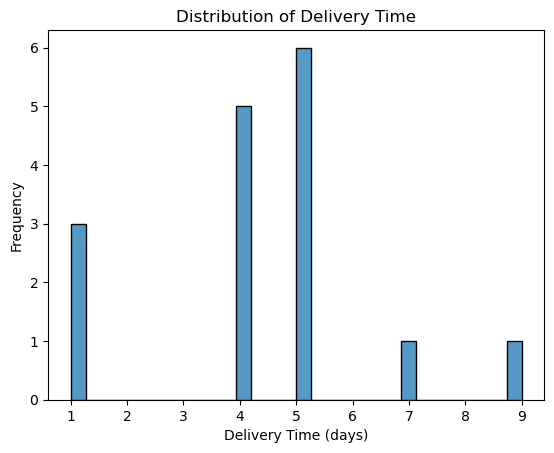

In [7]:
# Visualize the distribution of Late Deliverys
sns.histplot(late_df['DeliveryTime'], bins=30)
plt.title('Distribution of Delivery Time')
plt.xlabel('Delivery Time (days)')
plt.ylabel('Frequency')
plt.show()

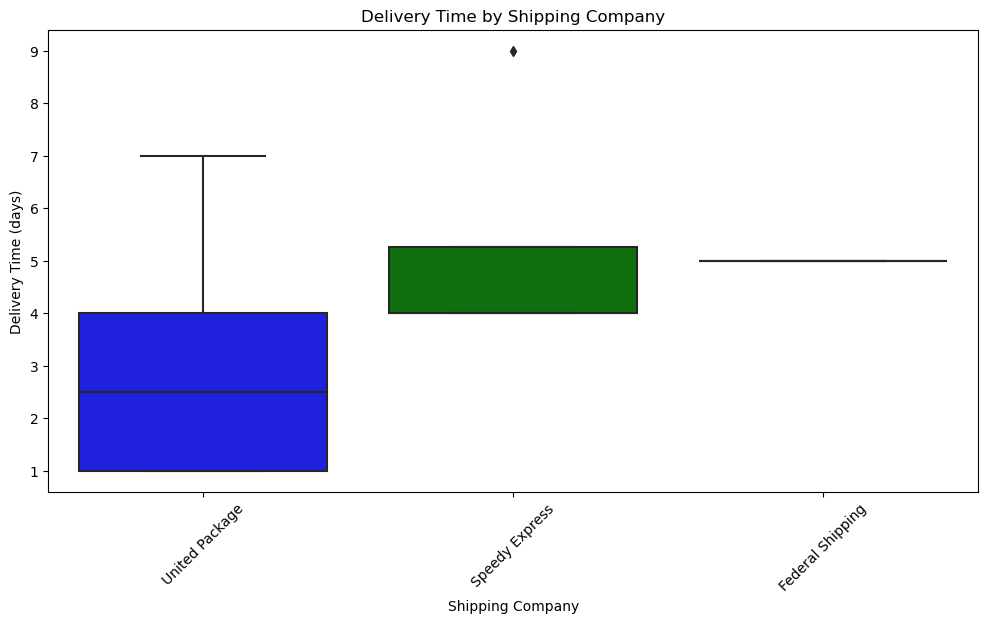

In [8]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=late_df, x='CompanyName', y='DeliveryTime', palette=['blue', 'green', 'red','black'])
plt.title('Delivery Time by Shipping Company')
plt.xlabel('Shipping Company')
plt.ylabel('Delivery Time (days)')
plt.xticks(rotation=45)
plt.show()


C:\Users\Okezie\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Okezie\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Okezie\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


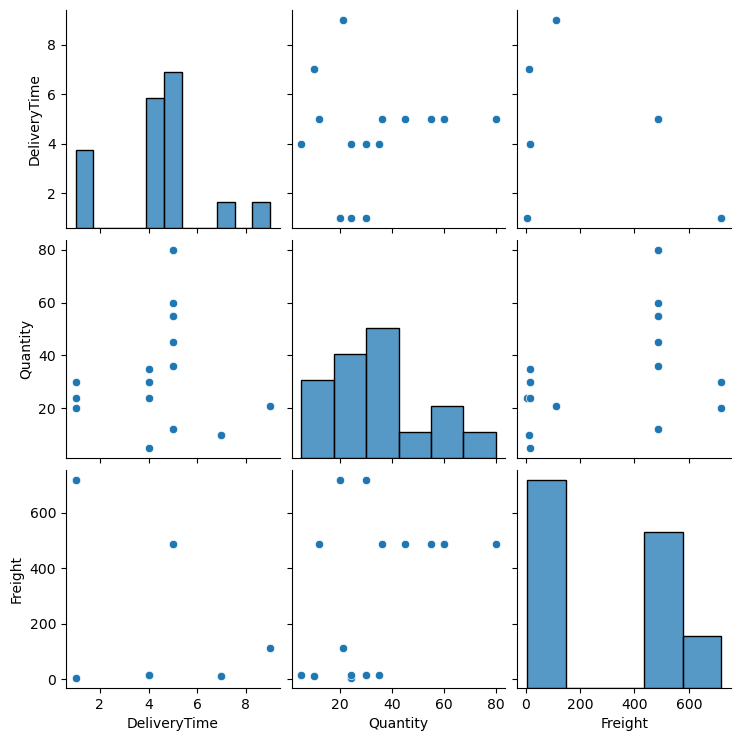

In [9]:
# Pairplot to see relationships between numerical variables
sns.pairplot(late_df[['DeliveryTime', 'Quantity', 'Freight']])
plt.show()

In [10]:
# EXPLORATORY ANALYSIS
model = smf.ols('DeliveryTime ~ CompanyName + Address + Freight + Quantity', data=late_df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           DeliveryTime   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.811e+27
Date:                Mon, 12 Aug 2024   Prob (F-statistic):          3.72e-108
Time:                        15:04:43   Log-Likelihood:                 467.07
No. Observations:                  16   AIC:                            -918.1
Df Residuals:                       8   BIC:                            -912.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

C:\Users\Okezie\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


# FINDING

In [11]:

"""
What We Are Looking At:

Delivery Time: This is the time it takes for goods to be delivered.

Companies: Delivery services like Speedy Express, United Package, Federal Shipping.

Addresses: These are different places where the goods are being delivered.

Freight: This is the cost of delivering the goods.

Quantity: This is the number of goods being delivered.

Intercept: This is like the base time it takes for any delivery. Imagine this is the time it takes if nothing else changes.

Company Names:
Speedy Express: If Speedy Express is delivering, it takes 1.6 days more than the base time.
United Package: If United Package is delivering, it takes 0.4 days more than the base time.

Addresses:
Delivering to some places like "City Center Plaza" takes 2.2 days more.
Delivering to others like "P.O. Box 555" takes 2.5 days less.

Freight (Cost):
Some costs make delivery time longer, like $11.92 increases it by 3.5 days.
Others make it shorter, like $16.34 decreases it by 0.6 days.

Quantity: The number of goods doesn't significantly affect the delivery time.

What the Numbers Mean:
The R-squared value is almost 1 (1.000). This means the factors we looked at explain almost all the reasons why delivery time changes.
The F-statistic is really high, meaning our findings are very strong and reliable.
P>|t| values are very small (close to 0), showing that these results are statistically significant, except for Quantity which isn't as important.

Extra Notes:
There might be some issues like multicollinearity, meaning some factors are too similar to each other, but that's something more technical.
In Simple Terms:
We found out which delivery companies, addresses, and freight costs make your goods arrive faster or slower. Some companies and addresses take longer,
while some make deliveries quicker. The cost of delivery also plays a big role. The quantity of goods ordered don't change the time much.
"""


'\nWhat We Are Looking At:\n\nDelivery Time: This is the time it takes for goods to be delivered.\n\nCompanies: Delivery services like Speedy Express, United Package, Federal Shipping.\n\nAddresses: These are different places where the goods are being delivered.\n\nFreight: This is the cost of delivering the goods.\n\nQuantity: This is the number of goods being delivered.\n\nIntercept: This is like the base time it takes for any delivery. Imagine this is the time it takes if nothing else changes.\n\nCompany Names:\nSpeedy Express: If Speedy Express is delivering, it takes 1.6 days more than the base time.\nUnited Package: If United Package is delivering, it takes 0.4 days more than the base time.\n\nAddresses:\nDelivering to some places like "City Center Plaza" takes 2.2 days more.\nDelivering to others like "P.O. Box 555" takes 2.5 days less.\n\nFreight (Cost):\nSome costs make delivery time longer, like $11.92 increases it by 3.5 days.\nOthers make it shorter, like $16.34 decreases i

## CONCLUSION:

In [12]:
""" 
the average delivering days for the three shipping companies

        CompanyName  AverageDeliveryTime
0  Federal Shipping                 5.00 days
1    Speedy Express                 5.25 days
2    United Package                 3.00 days

The United Package have lesser days while Speedy Express have the highest
Customer's Address and freight cost have a big affect on late delivering while quantity ordered doesn't 
significantly affect the delivery time.

"""


" \nthe average delivering days for the three shipping companies\n\n        CompanyName  AverageDeliveryTime\n0  Federal Shipping                 5.00 days\n1    Speedy Express                 5.25 days\n2    United Package                 3.00 days\n\nThe United Package have lesser days while Speedy Express have the highest\nCustomer's Address and freight cost have a big affect on late delivering while quantity ordered doesn't \nsignificantly affect the delivery time.\n\n"